In [1]:
import pandas as pd
import numpy as np
import random
from  math import log2
from collections import Counter
from cadsgen import generate_payload_agri_parcel_record
from entropies import shannon_entropy_kde
from shapley import sampling_kg
from scipy.stats import gaussian_kde
from scipy.stats import entropy
from sklearn.preprocessing import minmax_scale as scale
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tqdm


# METHODE DE CALCUL DES CONTRIBUTION
## VALEUR DE SHAPLEY
La valeur de shapley est utilisée comme porte d'entrée pour évaluer la contribution marginale de chaque participant. Cette valeur peut prendre toutes les valeurs sur l'ensemble des réels si la métrique qui carctérise "la valeur de la donnée" est non additive. Jusqu'ici j'étudie une approximation de l'entropie de shanon pour "caractériser la valeur de la donnée".


# CADS

In [5]:
records = []
for _ in range(100) :
    records.append(generate_payload_agri_parcel_record())
cads = pd.DataFrame(records)

In [6]:
cads_players = dict(player1 = list(cads.columns)[:5],
               player2= list(cads.columns)[5:10],
               player3= list(cads.columns)[10:15],
               player4= list(cads.columns)[15:20],
               player5= list(cads.columns)[20:30],
               player6= list(cads.columns)[30:40],
               player7= list(cads.columns)[40:])

In [7]:
shannon_entropy_kde(cads.values)

0.462098120373297

In [8]:
sampling_kg(cads, cads_players, 100)

{'player1': -0.006910017250010668,
 'player2': 0.004507107024069552,
 'player3': 0.0035102953644071564,
 'player4': -0.007296199250608379,
 'player5': -0.006446268779207484,
 'player6': 0.009251864510045366,
 'player7': 0.0005594687957376663}

# CROP - AUREA

In [3]:
aurea = pd.read_excel('aurea.xlsx')

In [4]:
aurea_players= dict(player1 = list(aurea.columns)[:5],
               player2= list(aurea.columns)[5:10],
               player3= list(aurea.columns)[10:15],
               player4= list(aurea.columns)[15:20],
               player5= list(aurea.columns)[20:30],
               player6= list(aurea.columns)[30:40],
               player7= list(aurea.columns)[40:])

In [5]:
shannon_entropy_kde(aurea.values)

0.6172804547851947

In [8]:
contribution = sampling_kg(aurea, aurea_players, 1000)
contribution

{'player1': -20.58717300375789,
 'player2': -22.46550431551651,
 'player3': -11.531741617421575,
 'player4': -29.516040725223235,
 'player5': -35.73188125953536,
 'player6': -4.263546457317649,
 'player7': 5.595919230873768}

In [10]:
def scaler(contributions: dict) :
    """_summary_

    Args:
        contributions (dict): _description_
    """
    binf = min(contributions.values())
    bsup = max(contributions.values())
    cont_scaled = {item: (value - binf) / (bsup - binf) for item, value in contributions.items()}
    return cont_scaled

In [14]:
scaled = scaler(contribution)
scaled

{'player1': 0.0,
 'player2': 0.869296656078675,
 'player3': 0.869296656078675,
 'player4': 0.869296656078675,
 'player5': 0.869296656078675,
 'player6': 0.869296656078675,
 'player7': 1.0}

In [11]:
def sigmoid(x : float, m:float = 1):
    """_summary_

    Args:
        x (float): _description_
        m (float, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    return 1 / (1 + np.exp(-m*x))


def get_scores(cont_scaled:dict, spread:float =1) -> dict :
    """_summary_

    Args:
        cont_scaled (dict): _description_

    Returns:
        dict: _description_
    """
    scores = {item: sigmoid(value,m=spread) for item, value in cont_scaled.items()}
    
    return scores
    


In [12]:
def get_weights(scores:dict) -> dict:
    """_summary_

    Args:
        scores (dict): _description_

    Returns:
        dict: _description_
    """
    weights = {item:round(100*value/sum(scores.values()),3) for item, value in scores.items()}
    
    return weights

In [17]:
weights = get_weights(get_scores(scaled,1))
weights

{'player1': 10.517,
 'player2': 14.821,
 'player3': 14.821,
 'player4': 14.821,
 'player5': 14.821,
 'player6': 14.821,
 'player7': 15.378}

expliquer le principe
grapher et voir les effet des étapes
expliquer je voulais juste une translation.

# EXPERIENCE

In [35]:
from itertools import combinations, chain
from math import factorial

# Données
revenues = {
    ('A',): 100,
    ('B',): 60,
    ('C',): 40,
    ('A', 'B'): 180,
    ('A', 'C'): 130,
    ('B', 'C'): 90,
    ('A', 'B', 'C'): 220
}

products = ['A', 'B', 'C']

def shapley_value(product, revenues):
    N = len(products)
    shap_value = 0
    
    # Tous les sous-ensembles sans le produit en question
    for subset in chain.from_iterable(combinations(products, r) for r in range(N)):
        if product not in subset:
            with_product = tuple(sorted(subset + (product,)))
            value_with = revenues.get(with_product, 0)
            value_without = revenues.get(subset, 0)

            # Calculer la contribution marginale
            marginal_contribution = value_with - value_without

            # Poids pour le sous-ensemble
            weight = factorial(len(subset)) * factorial(N - len(subset) - 1) / factorial(N)
            
            shap_value += weight * marginal_contribution

    return shap_value

# Calculer la valeur de Shapley pour chaque produit
shapley_values = {product: shapley_value(product, revenues) for product in products}

# Affichage des résultats
for product, value in shapley_values.items():
    print(f"La valeur de Shapley pour le produit {product} est: {value:.2f}€")


La valeur de Shapley pour le produit A est: 111.67€
La valeur de Shapley pour le produit B est: 71.67€
La valeur de Shapley pour le produit C est: 36.67€


In [36]:
sum(shapley_values.values())

219.99999999999997

In [20]:
scaler(shapley_values)

{'A': 1.0, 'B': 0.4343434343434342, 'C': 0.0}

In [37]:
weights = get_weights(get_scores(scaler(shapley_values),1))

In [38]:
weights

{'A': 39.61, 'B': 33.3, 'C': 27.091}

In [40]:
back_money = {item:round((value/100)*220,3) for item, value in weights.items()}
back_money

{'A': 87.142, 'B': 73.26, 'C': 59.6}

In [28]:
sum(back_money.values())

220.0

In [72]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Paramètre de la distribution exponentielle
lambda_param = 1.0  # par exemple, si vous voulez une moyenne de 1.0
size = 1000  # nombre de points à générer
mu = 1.0  # moyenne
sigma = 1.0

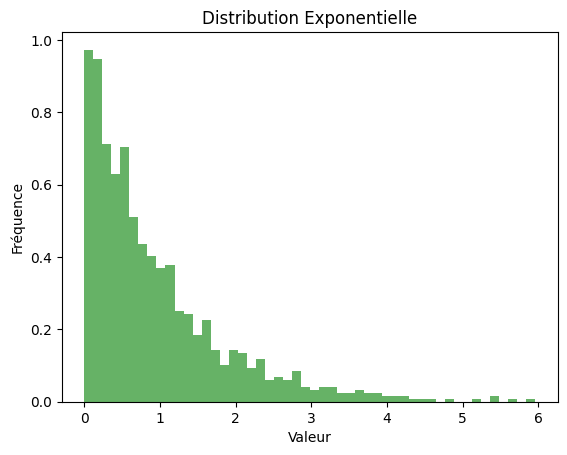

0.6791726788736968
0.8816303173523261


In [83]:
# Générer une distribution exponentielle
samples_e = np.random.exponential(scale=1/lambda_param, size=size)

# Visualiser la distribution
plt.hist(samples_e, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution Exponentielle')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.show()

print(shannon_entropy_kde(samples_e.reshape(size,1)))
print(np.var(samples_e))

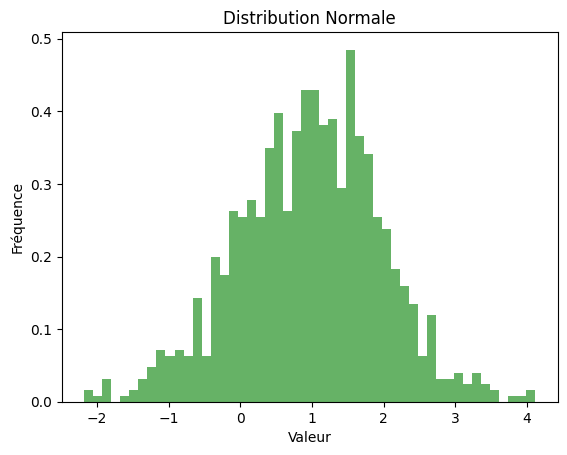

0.6838797362815795
0.9925385232072854


In [79]:
# Générer une distribution exponentielle
samples_n = np.random.normal(loc=mu, scale=sigma, size=size)

# Visualiser la distribution
plt.hist(samples_n, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution Normale')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.show()

print(shannon_entropy_kde(samples_n.reshape(size,1)))
print(np.var(samples_n))

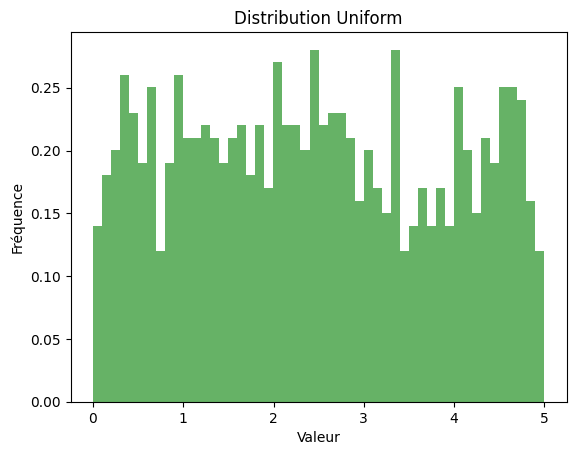

0.692144716904016
2.02356893743417


In [80]:
# Générer une distribution unifrom
a = 0
b = 5
samples_u = np.random.uniform(low=a, high=b, size=size)

# Visualiser la distribution
plt.hist(samples_u, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution Uniform')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.show()

print(shannon_entropy_kde(samples_u.reshape(size,1)))
print(np.var(samples_u))

In [95]:
def gennorm(samples:int = 30, mu:float = 0.0, std:float = 1.0, nanratio:float = 0.2):
    """_summary_

    Args:
        size (int, optional): _Nombre total d'échantillons_. Defaults to 30.
        mu (float, optional): _Moyenne de la distribution normale_. Defaults to 0.0.
        std (float, optional): _Écart-type de la distribution normale_. Defaults to 1.0.
        nanratio (float, optional): _Proportion de données manquantes_. Defaults to 0.2.
    Returns:
        _array_: _generated samples with specified missing values_
    """
    data = np.random.normal(loc=mu, scale=std, size=samples)
    missing_sample_size = int(samples*nanratio)
    missing_indices = np.random.choice(samples, missing_sample_size, replace=False)
    data[missing_indices] = np.nan
    return data

In [6]:
def kseuil(m:int = 100, epsilon:float = 0.1, sigma:float = 0.1) :
    """_summary_

    Args:
        m (nombre de joueurs, optional): _description_. Defaults to 100.
        epsilon (précision, optional): _description_. Defaults to 0.1.
        sigma (erreur de type I, optional): _description_. Defaults to 0.1.

    Returns:
        _int_: _nombre minimale d'échantillonnage pour avoir |shap_approx - shap| < epsilon avec la certitude 1 - sigma_
    """
    return int((m*np.log(2/sigma))/(2*(epsilon**2)))

In [11]:
np.linspace(0.001, 1, 100)

array([0.001     , 0.01109091, 0.02118182, 0.03127273, 0.04136364,
       0.05145455, 0.06154545, 0.07163636, 0.08172727, 0.09181818,
       0.10190909, 0.112     , 0.12209091, 0.13218182, 0.14227273,
       0.15236364, 0.16245455, 0.17254545, 0.18263636, 0.19272727,
       0.20281818, 0.21290909, 0.223     , 0.23309091, 0.24318182,
       0.25327273, 0.26336364, 0.27345455, 0.28354545, 0.29363636,
       0.30372727, 0.31381818, 0.32390909, 0.334     , 0.34409091,
       0.35418182, 0.36427273, 0.37436364, 0.38445455, 0.39454545,
       0.40463636, 0.41472727, 0.42481818, 0.43490909, 0.445     ,
       0.45509091, 0.46518182, 0.47527273, 0.48536364, 0.49545455,
       0.50554545, 0.51563636, 0.52572727, 0.53581818, 0.54590909,
       0.556     , 0.56609091, 0.57618182, 0.58627273, 0.59636364,
       0.60645455, 0.61654545, 0.62663636, 0.63672727, 0.64681818,
       0.65690909, 0.667     , 0.67709091, 0.68718182, 0.69727273,
       0.70736364, 0.71745455, 0.72754545, 0.73763636, 0.74772

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Définir les coordonnées des points du maillage
s = np.linspace(0.001, 1, 100)
e = np.linspace(0.001, 1, 100)
m = np.arange(1,101)
M, S = np.meshgrid(m, s)
M, E = np.meshgrid(m, e)
Ze = (M*np.log(2/0.1))/(2*(E**2))

# Créer une figure 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer la surface en utilisant les coordonnées du maillage
ax.plot_surface(M, E, Ze, cmap='viridis')

# Afficher le maillage 3D
plt.show()


In [14]:
contrib = {f"player{i}" : value for i, value in enumerate(np.linspace(-0.001,0.01,100).tolist())}

In [21]:
contrib['player99'] = 10

In [22]:
get_weights(get_scores(scaler({f"player{i}" : value for i, value in enumerate(np.linspace(-0.001,0.01,100).tolist())}),1))

{'player0': 0.806,
 'player1': 0.81,
 'player2': 0.815,
 'player3': 0.819,
 'player4': 0.823,
 'player5': 0.827,
 'player6': 0.831,
 'player7': 0.835,
 'player8': 0.839,
 'player9': 0.843,
 'player10': 0.847,
 'player11': 0.851,
 'player12': 0.855,
 'player13': 0.859,
 'player14': 0.863,
 'player15': 0.867,
 'player16': 0.871,
 'player17': 0.875,
 'player18': 0.879,
 'player19': 0.884,
 'player20': 0.888,
 'player21': 0.892,
 'player22': 0.896,
 'player23': 0.9,
 'player24': 0.904,
 'player25': 0.908,
 'player26': 0.912,
 'player27': 0.916,
 'player28': 0.92,
 'player29': 0.924,
 'player30': 0.928,
 'player31': 0.932,
 'player32': 0.936,
 'player33': 0.94,
 'player34': 0.943,
 'player35': 0.947,
 'player36': 0.951,
 'player37': 0.955,
 'player38': 0.959,
 'player39': 0.963,
 'player40': 0.967,
 'player41': 0.971,
 'player42': 0.975,
 'player43': 0.979,
 'player44': 0.983,
 'player45': 0.987,
 'player46': 0.99,
 'player47': 0.994,
 'player48': 0.998,
 'player49': 1.002,
 'player50': 1.0

In [22]:
normparams = {'taille': [15, 30, 60, 120, 240, 480, 960, 1920],
          'mu':[0, 5, 15, 35, 75, 155],
          'sigma':[np.linspace(0.1, 1, 10),
                   np.linspace(0.1, 1, 10),
                   np.linspace(0.1, 3, 10),
                   np.linspace(0.1, 7, 10),
                   np.linspace(0.1, 15, 10),
                   np.linspace(0.1, 31, 10)]}

uniparams = {'taille': [15, 30, 60, 120, 240, 480, 960, 1920],
          'center':[0, 5, 15, 35, 75, 155],
          'range':[np.linspace(0.1, 1, 10),
                   np.linspace(0.1, 1, 10),
                   np.linspace(0.1, 3, 10),
                   np.linspace(0.1, 7, 10),
                   np.linspace(0.1, 15, 10),
                   np.linspace(0.1, 31, 10)]}

expparams = {'taille': [15, 30, 60, 120, 240, 480, 960, 1920],
          'lambda':np.linspace(0.0064, 1000, 6).tolist()}

In [19]:
def genexpoxp(params:dict) :
    np.random.seed(7)
    data = {'id':[],
            'dist':[],
            'baseh':[],
            'basemu':[],
            'basemed':[],
            'basestd':[],
            'scaledh':[],
            'scaledmu':[],
            'scaledmed':[],
            'scaledstd':[],
            'taille':[],
            'bins':[]}
    
    for t in params['taille'] :
        bin = int(np.sqrt(t))
        for l in params['lambda'] :
            data['id'].append(f"exp_{t}_{round(l,2)*1000}")
            data['taille'].append(t)
            data['bins'].append(bin)

            sample = np.random.exponential(scale=1/l, size=t)
            freq = np.histogram(sample, bins=bin, density=False)[0]/t
            data['baseh'].append(entropy(freq, base = 2))
            data['basemu'].append(np.mean(sample))
            data['basemed'].append(np.median(sample))
            data['basestd'].append(np.std(sample))

            sample = scale(sample)
            freq = np.histogram(sample, bins=bin, density=False)[0]/t
            data['scaledh'].append(entropy(freq, base = 2))
            data['scaledmu'].append(np.mean(sample))
            data['scaledmed'].append(np.median(sample))
            data['scaledstd'].append(np.std(sample))
            
    data['dist'] = ['exp']*len(data['id'])
    return data



def gennormxp(params:dict) :
    np.random.seed(7)
    data = {'id':[],
            'dist':[],
            'baseh':[],
            'basemu':[],
            'basemed':[],
            'basestd':[],
            'scaledh':[],
            'scaledmu':[],
            'scaledmed':[],
            'scaledstd':[],
            'taille':[],
            'bins':[]}
    
    for t in params['taille'] :
        bin = int(np.sqrt(t))
        for m in range(len(params['mu'])):
            for s in params['sigma'][m] :
                data['id'].append(f"norm_{t}_{m}_{round(s,2)*1000}")
                data['taille'].append(t)
                data['bins'].append(bin)
                
                sample = np.random.normal(loc=m, scale=s, size=t)
                freq = np.histogram(sample, bins=bin, density=False)[0]/t
                data['baseh'].append(entropy(freq, base = 2))
                data['basemu'].append(np.mean(sample))
                data['basemed'].append(np.median(sample))
                data['basestd'].append(np.std(sample))
                
                sample = scale(sample)
                freq = np.histogram(sample, bins=bin, density=False)[0]/t
                data['scaledh'].append(entropy(kde(sample), base = 2))
                data['scaledmu'].append(np.mean(sample))
                data['scaledmed'].append(np.median(sample))
                data['scaledstd'].append(np.std(sample))

    data['dist'] = ['norm']*len(data['id'])
    return data

def genunixp(params:dict) :
    np.random.seed(7)
    data = {'id':[],
            'dist':[],
            'baseh':[],
            'basemu':[],
            'basemed':[],
            'basestd':[],
            'scaledh':[],
            'scaledmu':[],
            'scaledmed':[],
            'scaledstd':[],
            'taille':[],
            'bins':[]}
    
    for t in params['taille'] :
        bin = int(np.sqrt(t))
        for c in range(len(params['center'])):
            for r in params['range'][c] :
                data['id'].append(f"uni{t}_{c}_{round(r,2)*1000}")
                data['taille'].append(t)
                data['bins'].append(bin)
                
                sample = np.random.uniform(low=(c-r), high=(c+r), size=t)
                freq = np.histogram(sample, bins=bin, density=False)[0]/t
                data['baseh'].append(entropy(freq, base = 2))
                data['basemu'].append(np.mean(sample))
                data['basemed'].append(np.median(sample))
                data['basestd'].append(np.std(sample))
                
                sample = scale(sample)
                freq = np.histogram(sample, bins=bin, density=False)[0]/t
                data['scaledh'].append(entropy(freq, base = 2))
                data['scaledmu'].append(np.mean(sample))
                data['scaledmed'].append(np.median(sample))
                data['scaledstd'].append(np.std(sample))

    data['dist'] = ['uni']*len(data['id'])
    return data

In [ ]:
normdf = pd.DataFrame(gennormxp(normparams))

In [65]:
normdf = pd.DataFrame(gennormxp(normparams))
expdf = pd.DataFrame(genexpoxp(expparams))
unidf = pd.DataFrame(genunixp(uniparams))

xpdf = pd.concat([normdf,expdf, unidf])

In [68]:
xpdf.to_csv('expdf_hist.csv')

In [67]:
xpdf['e_base'] = xpdf['baseh']/np.log2(xpdf['bins'])
xpdf['e_scale'] = xpdf['scaledh']/np.log2(xpdf['bins'])

In [64]:
xpdf

,id,dist,baseh,basemu,basemed,basestd,scaledh,scaledmu,scaledmed,scaledstd,taille,bins,e_norm,e_base,e_scale
0,norm_15_0_100.0,norm,1.370951,-0.000368,-0.000089,0.078072,3.899247,0.508249,0.509059,0.226606,15,3,0.350906,0.864974,2.460151
1,norm_15_0_200.0,norm,1.456565,-0.028488,-0.009077,0.232858,3.896576,0.497032,0.519511,0.269675,15,3,0.372819,0.918990,2.458466
2,norm_15_0_300.0,norm,1.565596,-0.061003,-0.098824,0.347765,3.894366,0.485846,0.452935,0.302622,15,3,0.400727,0.987781,2.457072
3,norm_15_0_400.0,norm,1.370951,0.074637,0.094921,0.412057,3.897010,0.491197,0.503716,0.254312,15,3,0.350906,0.864974,2.458740
4,norm_15_0_500.0,norm,1.565596,-0.046904,-0.150097,0.549974,3.890318,0.502665,0.445429,0.305040,15,3,0.400727,0.987781,2.454517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,uni1920_5_17270.0,uni,5.408120,5.374545,5.925162,10.027918,5.408120,0.511257,0.527219,0.290707,1920,43,0.495844,0.996656,0.996656
476,uni1920_5_20700.0,uni,5.407822,4.696424,4.630449,12.012117,5.407822,0.493002,0.491406,0.290429,1920,43,0.495817,0.996601,0.996601
477,uni1920_5_24130.0,uni,5.413472,4.586088,4.476945,14.042830,5.413472,0.491425,0.489164,0.290968,1920,43,0.496335,0.997642,0.997642
478,uni1920_5_27570.0,uni,5.412300,5.303185,5.436791,15.836185,5.412300,0.505470,0.507894,0.287279,1920,43,0.496228,0.997427,0.997427


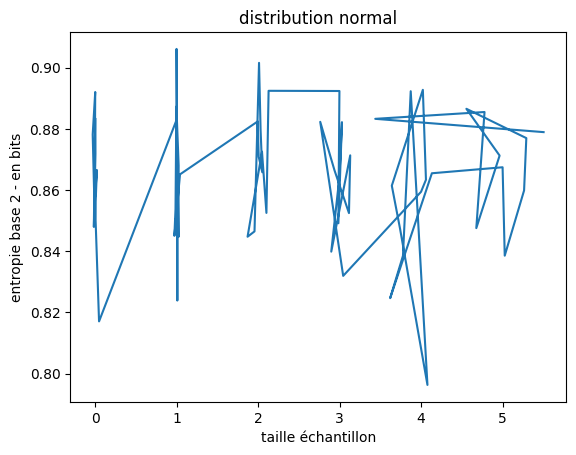

In [73]:
# Données des valeurs x et y
x = xpdf[(xpdf['dist']=='norm')&(xpdf['bins']==30)]['basemu']
y = xpdf[(xpdf['dist']=='norm')&(xpdf['bins']==30)]['e_base']

# Tracer la courbe
plt.plot(x, y)

# Ajouter un titre et des étiquettes d'axe
plt.title("distribution normal")
plt.xlabel("taille échantillon")
plt.ylabel("entropie base 2 - en bits")

# Afficher la courbe
plt.show()


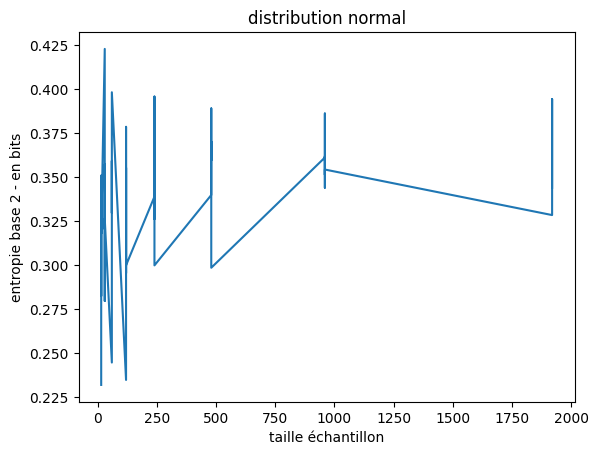

In [51]:
# Données des valeurs x et y
x = xpdf[xpdf['dist']=='exp']['taille']
y = xpdf[xpdf['dist']=='exp']['baseh']/np.log2(x)

# Tracer la courbe
plt.plot(x, y)

# Ajouter un titre et des étiquettes d'axe
plt.title("distribution normal")
plt.xlabel("taille échantillon")
plt.ylabel("entropie base 2 - en bits")

# Afficher la courbe
plt.show()
print()

In [50]:
np.min(y)

-1151.428494870052

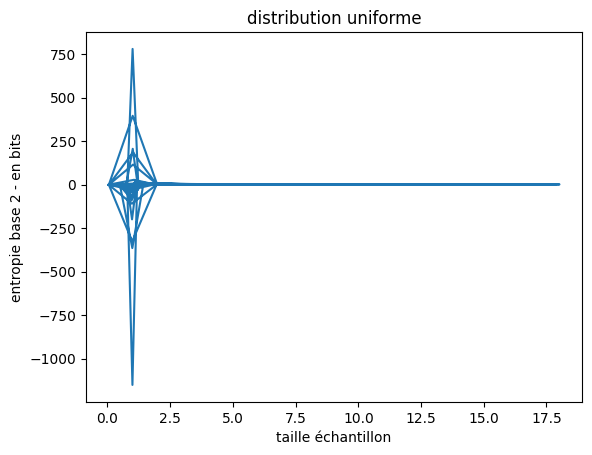

In [49]:
# Données des valeurs x et y
x = xpdf[xpdf['dist']=='uni']['basestd']
y = xpdf[xpdf['dist']=='uni']['baseh']/np.log2(x)

# Tracer la courbe
plt.plot(x, y)

# Ajouter un titre et des étiquettes d'axe
plt.title("distribution uniforme")
plt.xlabel("taille échantillon")
plt.ylabel("entropie base 2 - en bits")

# Afficher la courbe
plt.show()


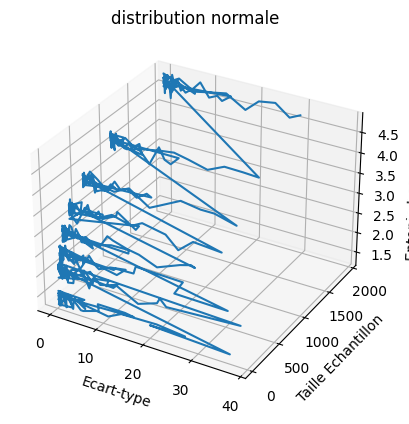

In [42]:
# Données des valeurs x et y
x = xpdf[xpdf['dist']=='norm']['basestd']
y = xpdf[xpdf['dist']=='norm']['taille']
z = xpdf[xpdf['dist']=='norm']['baseh']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z)
ax.set_title("distribution normale")
ax.set_xlabel("Ecart-type")
ax.set_ylabel("Taille Echantillon")
ax.set_zlabel("Entopie base 2 en bits")

# Afficher la courbe
plt.show()

In [43]:
# Données des valeurs x, y et z
x = xpdf[xpdf['dist']=='norm']['basestd']
y = xpdf[xpdf['dist']=='norm']['taille']
z = xpdf[xpdf['dist']=='norm']['baseh']

# Tracer la surface 3D
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z)])

# Ajouter un titre et des étiquettes d'axe
fig.update_layout(title="distribution normale",
                  scene=dict(
                      xaxis_title="Ecart-type",
                      yaxis_title="Taille Echantillon",
                      zaxis_title="Entopie base 2 en bits"
                  ))

# Afficher la courbe
fig.show()


In [12]:
kde = gaussian_kde(np.random.normal(loc=0, scale=1, size=1000))
b = kde(np.random.normal(loc=0, scale=1, size=1000))

In [14]:
sum(b)

278.32170839566794

Variance expliquée par chaque composante:
[9.79965438e-01 1.88052682e-02 1.16418850e-03 4.14647416e-05
 1.03674783e-05 9.50715729e-06 3.54405336e-06 1.23781993e-07
 7.44011710e-08 1.87274551e-08 3.48185075e-09 6.65883989e-10
 4.39918330e-10]

Variance expliquée cumulée par chaque composante:
[0.97996544 0.99877071 0.9999349  0.99997636 0.99998673 0.99999623
 0.99999978 0.9999999  0.99999998 1.         1.         1.
 1.        ]


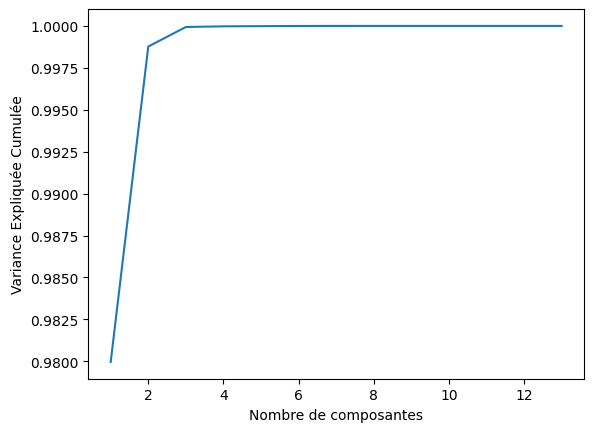

In [75]:
from sklearn.decomposition import PCA
import pandas as pd

# Charger les données dans un DataFrame
data = pd.read_csv('expdf_hist.csv')

# Séparer les données en variables explicatives (X) et variable cible (y) si nécessaire
X = data.drop(['id', 'dist'], axis=1)
#y = data['variable_cible']

# Créer une instance de l'objet PCA
pca = PCA()

# Appliquer l'ACP sur les données
X_reduced = pca.fit_transform(X)

# Visualiser la variance expliquée cumulée
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Afficher les résultats
print("Variance expliquée par chaque composante:")
print(explained_variance_ratio)
print("\nVariance expliquée cumulée par chaque composante:")
print(cumulative_variance_ratio)

# Tracer le graphique de variance expliquée cumulée
import matplotlib.pyplot as plt
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance Expliquée Cumulée')
plt.show()


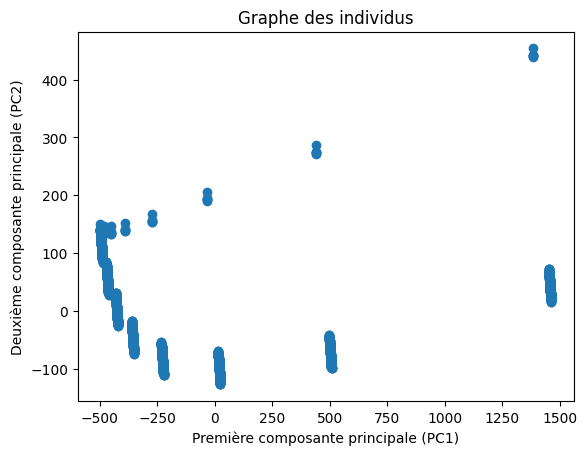

In [76]:
# Charger les données dans un DataFrame
data = pd.read_csv('expdf_hist.csv')

# Séparer les données en variables explicatives (X) et variable cible (y) si nécessaire
X = data.drop(['id', 'dist'], axis=1)
#y = data['variable_cible']

# Créer une instance de l'objet PCA
pca = PCA()

# Appliquer l'ACP sur les données
X_reduced = pca.fit_transform(X)

# Tracer le graphe des individus
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.xlabel('Première composante principale (PC1)')
plt.ylabel('Deuxième composante principale (PC2)')
plt.title('Graphe des individus')
plt.show()


In [ ]:
qualitatives = ['dist']
quantitatives = ['bins', 'basestd', 'basemu','basemed']
dependante = ['e_base']

In [10]:
# Données
data = pd.read_csv("expdf_hist.csv")  # Remplacez "data.csv" par le nom de votre fichier de données

# Variables qualitatives
qualitatives = ['C(dist)']

# Variables quantitatives
quantitatives = ['basestd','basemu','basemed', 'bins'] #, 'basemu','basemed'

# Variable dépendante
dependante = 'e_base'

# Construction du modèle
formula = dependante + ' ~ ' + ' * '.join(qualitatives + quantitatives)
model = ols(formula, data=data).fit()

# Affichage des résultats
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 e_base   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     90.07
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          8.20e-316
Time:                        13:36:36   Log-Likelihood:                 1992.6
No. Observations:                1008   AIC:                            -3889.
Df Residuals:                     960   BIC:                            -3653.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
qualitatives = ['dist']
quantitatives = ['bins', 'basestd', 'basemu','basemed']
dependante = ['e_base']

In [11]:
formula

'e_base ~ C(dist) * basestd * basemu * basemed * bins'

In [ ]:
ols("np.log(Days+1) ~ C(Duration) + C(Weight, Sum)", data=kt).fit()

In [ ]:
qualitatives = ['dist']
quantitatives = ['bins', 'basestd', 'basemu','basemed']
dependante = ['e_base']

In [78]:

nan_size = int(sz*nanratio)
nan_idx = np.random.choice(sz, nan_size, replace=False)
data[nan_idx] = np.nan
freq = np.histogram(data, bins = int(np.sqrt(sz)), density = False)[0]/sz
e = entropy(freq, base = 2)
e

4.3453236996833065

0.7663099886578351
101 10000


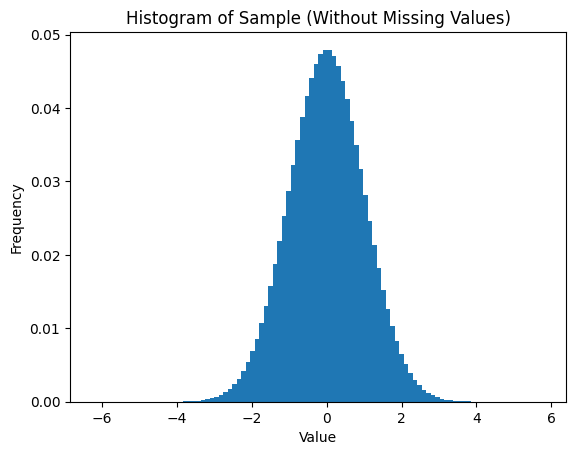

In [18]:
np.random.seed(7)
sz = 100000000
nanratio=0.0
data = np.random.normal(loc=0, scale=1, size=sz)
hist, bins = np.histogram(data, bins=100, density=False)
hist = hist/sz
e = entropy(hist, base = 2)/np.log2(bins.shape[0])
print(e)
print(bins.shape[0], int(np.sqrt(sz)))
plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Sample (Without Missing Values)')
plt.show()

In [20]:
def gennormxp(params:dict) :
    np.random.seed(7)
    data = {'id':[],
            'dist':[],
            'baseh':[],
            'basemu':[],
            'basemed':[],
            'basestd':[],
            'taille':[],
            'bins':[]}
    
    for t in params['taille'] :
        for m in range(len(params['mu'])):
            for s in params['sigma'][m] :
                data['id'].append(f"norm_{t}_{m}_{round(s,2)*1000}")
                data['taille'].append(t)
                
                sample = np.random.normal(loc=m, scale=s, size=t)
                freq = np.histogram(sample, bins='doane', density=False)[0]/t
                bin = freq.shape[0]
                data['bins'].append(bin)
                data['baseh'].append(entropy(freq, base = 2))
                data['basemu'].append(np.mean(sample))
                data['basemed'].append(np.median(sample))
                data['basestd'].append(np.std(sample))

    data['dist'] = ['norm']*len(data['id'])
    return data

In [23]:
normdf = pd.DataFrame(gennormxp(normparams))

In [24]:
normdf

,id,dist,baseh,basemu,basemed,basestd,taille,bins
0,norm_15_0_100.0,norm,2.105587,-0.000368,-0.000089,0.078072,15,5
1,norm_15_0_200.0,norm,2.365596,-0.028488,-0.009077,0.232858,15,6
2,norm_15_0_300.0,norm,2.149255,-0.061003,-0.098824,0.347765,15,6
3,norm_15_0_400.0,norm,2.332915,0.074637,0.094921,0.412057,15,6
4,norm_15_0_500.0,norm,2.173557,-0.046904,-0.150097,0.549974,15,6
...,...,...,...,...,...,...,...,...
475,norm_1920_5_17270.0,norm,2.913937,4.528168,4.823210,18.033490,1920,14
476,norm_1920_5_20700.0,norm,2.984988,4.951880,5.043608,20.870873,1920,12
477,norm_1920_5_24130.0,norm,3.155973,5.764590,5.833160,24.356104,1920,13
478,norm_1920_5_27570.0,norm,2.911293,5.223785,5.475844,27.402475,1920,13


In [68]:
normdf['bins'].unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [75]:
normdf[normdf['bins']==5]

,id,dist,baseh,basemu,basemed,basestd,taille,bins,cste,e
0,norm_15_0_100.0,norm,2.105587,-0.000368,-0.000089,0.078072,15,5,1,0.906827
47,norm_15_4_11690.0,norm,2.256565,8.737292,10.524224,11.444526,15,5,1,0.971850


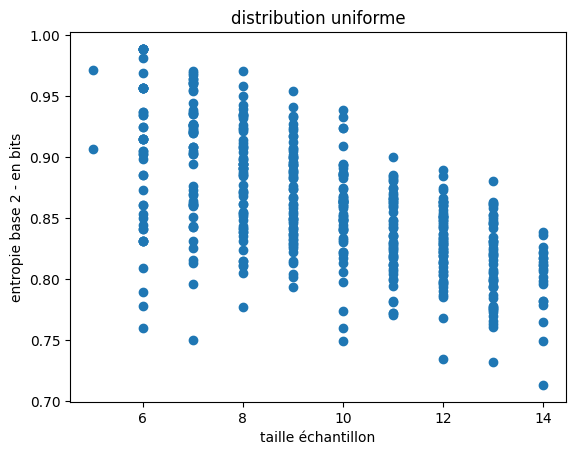

In [79]:
# Données des valeurs x et y
#x = normdf[normdf['taille']==15]['basestd']
#y = normdf[normdf['taille']==15]['e']

x = normdf['bins']
y = normdf['e']
# Tracer la courbe
plt.scatter(x, y)

# Ajouter un titre et des étiquettes d'axe
plt.title("distribution uniforme")
plt.xlabel("taille échantillon")
plt.ylabel("entropie base 2 - en bits")

# Afficher la courbe
plt.show()

In [88]:
import plotly.graph_objects as go

# Sample data
x = normdf['bins']
y = normdf['e']
text = normdf['basestd']
# Create scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers', hovertext=text))

# Add labels and title
fig.update_layout(
    xaxis=dict(title='X-axis'),
    yaxis=dict(title='Y-axis'),
    title='Scatter Plot'
)

# Show the plot
fig.show()


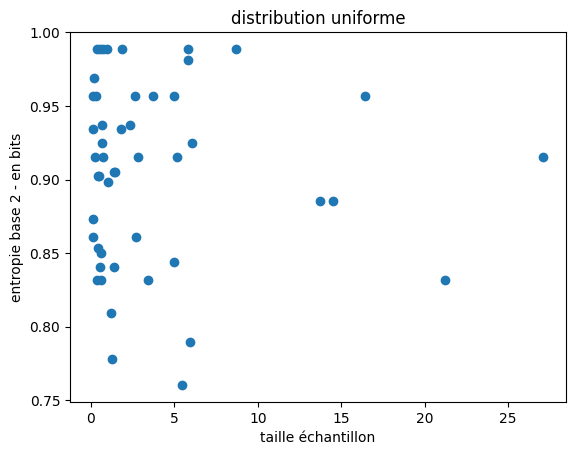

In [73]:

sorted_df = normdf.sort_values(by='e')

# Données des valeurs x et y
x = normdf[normdf['bins']==6]['basestd']
y = normdf[normdf['bins']==6]['e']

# Tracer la courbe
plt.scatter(x, y)

# Ajouter un titre et des étiquettes d'axe
plt.title("distribution uniforme")
plt.xlabel("taille échantillon")
plt.ylabel("entropie base 2 - en bits")

# Afficher la courbe
plt.show()

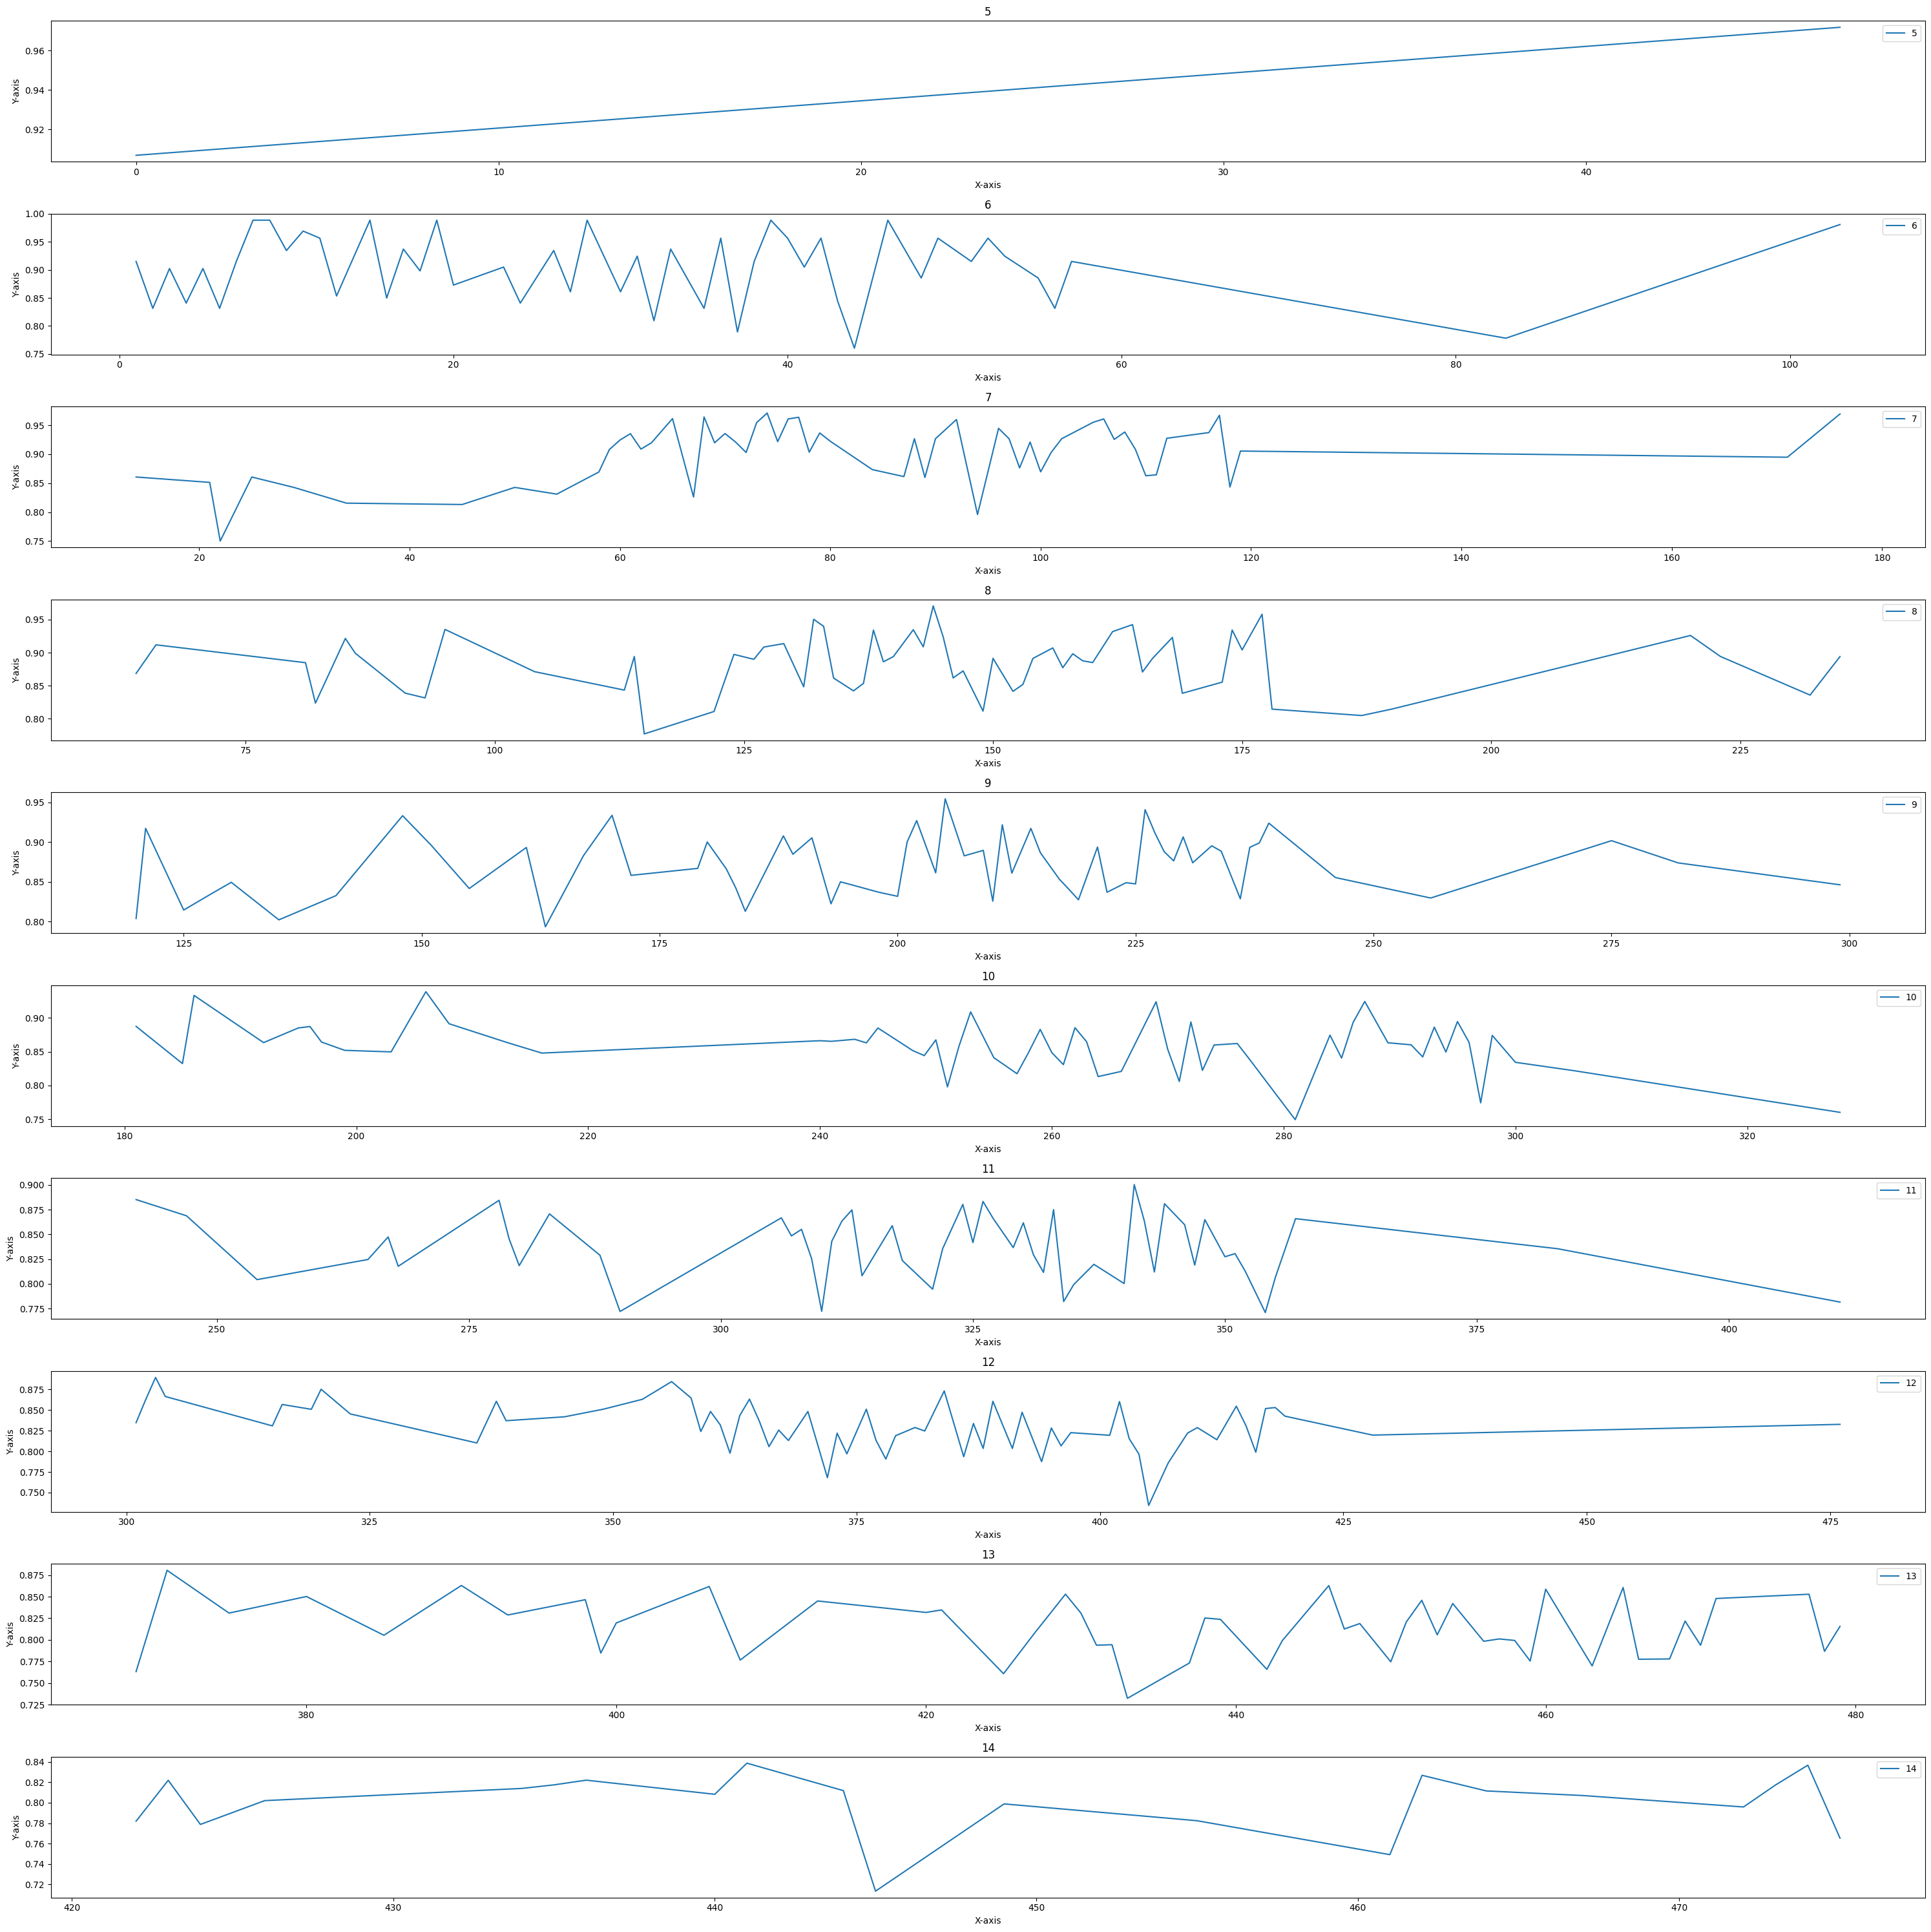

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'df' with a categorical column named 'category'
# and a numerical column named 'value'

# Group the data based on the categorical column
grouped_data = normdf.groupby('bins')

# Get the unique categories in the categorical column
categories = normdf['bins'].unique()

# Determine the number of subplots
num_subplots = len(categories)

# Create subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(30, 30))

# Iterate through the groups and plot each group separately
for i, (category, group) in enumerate(grouped_data):
    # Plot the values of each group
    axs[i].plot(group['baseh']/np.log2(group['bins']), label=category)
    axs[i].set_title(category)
    axs[i].set_xlabel('X-axis')
    axs[i].set_ylabel('Y-axis')
    axs[i].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [66]:
# Variables qualitatives
#qualitatives = ['C(dist)']

# Variables quantitatives
quantitatives = ['basestd', 'bins', 'basemed', 'basemu'] #, 'basemu','basemed'
normdf['cste']=[1]*normdf.shape[0]
normdf['e'] = normdf['baseh']/np.log2(normdf['bins'])
# Variable dépendante
dependante = 'baseh'

# Construction du modèle
formula = dependante + ' ~ ' + '+'.join(quantitatives)+'+'+'*'.join(quantitatives)#.join(qualitatives + quantitatives)
model = ols(formula, data=normdf).fit()

# Affichage des résultats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  baseh   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     77.22
Date:                Mon, 07 Aug 2023   Prob (F-statistic):          1.22e-115
Time:                        01:49:17   Log-Likelihood:                 284.43
No. Observations:                 480   AIC:                            -536.9
Df Residuals:                     464   BIC:                            -470.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:
qualitatives = ['dist']
quantitatives = ['bins', 'basestd', 'basemu','basemed']
dependante = ['e_base']

In [ ]:
qualitatives = ['dist']
quantitatives = ['bins', 'basestd', 'basemu','basemed']
dependante = ['e_base']

In [59]:
formula

'baseh ~ cste+basestd+binscste*basestd*bins'

In [65]:
normdf['basestd'].unique()

array([ 0.07807159,  0.23285786,  0.34776549,  0.41205659,  0.54997368,
        0.50751477,  0.58840646,  0.70129182,  0.53378558,  0.73187125,
        0.11415836,  0.16149222,  0.30486668,  0.44618061,  0.34902684,
        0.36062102,  0.60430958,  0.68051551,  0.99444128,  0.96437314,
        0.09428354,  0.4533795 ,  0.65559558,  1.41910503,  1.35065676,
        1.80879083,  1.77246021,  2.69739322,  1.8334026 ,  3.2529488 ,
        0.10356487,  0.65853666,  1.21993502,  2.337652  ,  3.2638127 ,
        3.43631594,  3.69270976,  5.94107332,  5.13203728,  5.81384463,
        0.11211663,  1.37542068,  2.63129803,  4.95661704,  5.47790616,
        8.85059801,  8.71355272, 11.44452599, 14.52036329, 16.40242882,
        0.09506598,  2.79788208,  4.98168809,  6.05788681, 10.90518079,
       13.72424742, 21.19917145, 27.11376215, 19.79335016, 36.28449974,
        0.07907524,  0.17633028,  0.27119353,  0.36753431,  0.49233432,
        0.62983612,  0.84102257,  0.63592959,  0.81987545,  1.27

In [ ]:
x = normdf['bins'], y = normdf['baseh']

ValueError: Dimensions of labels and X must be compatible

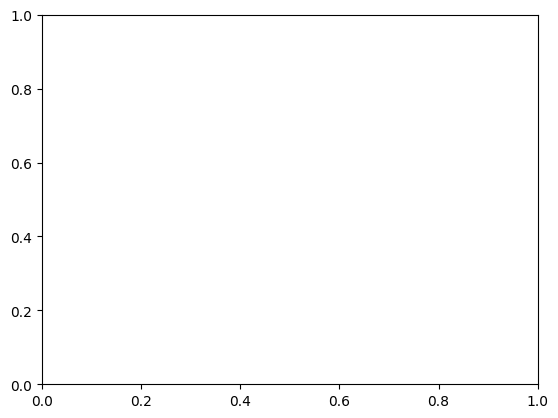

In [67]:
import matplotlib.pyplot as plt

# Retrieve x and y values from the dataframe
x = normdf['bins']
y = normdf['baseh']

# Create a figure and axes
fig, ax = plt.subplots()

# Create the boxplot with x and y values
ax.boxplot(y, labels=x)

# Set axis labels and title 
ax.set_xlabel('Bins')
ax.set_ylabel('Baseh')
ax.set_title('Boxplot of Bins')

# Show the plot
plt.show()


In [2]:
def gennormxp(params:dict) :
    np.random.seed(7)
    data = {'id':[],
            'dist':[],
            'baseh':[],
            'taille':[],
            'bins':[]}
    
    for t in params['taille'] :
        data['id'].append(f"norm_{t}_{0}_{round(1,2)*1000}")
        data['taille'].append(t)            
        sample = np.random.normal(loc=0, scale=1, size=t)
        freq = np.histogram(sample, bins='doane', density=False)[0]/t
        bin = freq.shape[0]
        data['bins'].append(bin)
        data['baseh'].append(entropy(freq, base = 2))

    data['dist'] = ['norm']*len(data['id'])
    return data

In [45]:
normparams = {'taille':[15, 1000, 100000, 1000000, 2000000, 4000000, 6000000, 8000000, 10000000],
          'mu':[0, 5, 15, 35, 75, 155],
          'sigma':[np.linspace(0.1, 1, 10),
                   np.linspace(0.1, 1, 10),
                   np.linspace(0.1, 3, 10),
                   np.linspace(0.1, 7, 10),
                   np.linspace(0.1, 15, 10),
                   np.linspace(0.1, 31, 10)]}

In [46]:
df = pd.DataFrame(gennormxp(normparams))

In [47]:
df['e']= df['baseh']/np.log2(df['bins'])

In [48]:
import plotly.graph_objects as go

# Sample data
x = df['taille']
y = df['e']
# Create scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers'))

# Add labels and title
fig.update_layout(
    xaxis=dict(title='X-axis'),
    yaxis=dict(title='Y-axis'),
    title='Scatter Plot'
)

# Show the plot
fig.show()


In [ ]:
nan_size = int(sz*nanratio)
nan_idx = np.random.choice(sz, nan_size, replace=False)
data[nan_idx] = np.nan
freq = np.histogram(data, bins = int(np.sqrt(sz)), density = False)[0]/sz
e = entropy(freq, base = 2)
e

In [ ]:
def gennormxp(params:dict) :
    np.random.seed(7)
    data = {'id':[],
            'dist':[],
            'baseh':[],
            'taille':[],
            'nan_ratio':[],
            'bins':[]}
    
    for t in params['taille'] :
        data['id'].append(f"norm_{t}_{0}_{round(1,2)*1000}")
        data['taille'].append(t)            
        sample = np.random.normal(loc=0, scale=1, size=t)
        freq = np.histogram(sample, bins='doane', density=False)[0]/t
        bin = freq.shape[0]
        data['bins'].append(bin)
        data['baseh'].append(entropy(freq, base = 2))

    data['dist'] = ['norm']*len(data['id'])
    return data

In [49]:
np.argmin(np.linspace(0,1, 100))

0

In [ ]:
np.where()

In [50]:
sample = np.random.normal(loc=0, scale=1, size=100)
hist = np.histogram(sample, bins='doane', density = False)

In [7]:
def delete_values(sample:np.array, hist:tuple, ratio:float, size:int):
    array = sample.copy()
    to_delete = int(ratio*size)
    nb_to_delete_by_range = [0]*hist[0].shape[0]
    rg_sorted = np.argsort(hist[0]).tolist()
    i = 0
    while to_delete > 0 and i < len(rg_sorted):
        if hist[0][i] > 1:
            nb_to_delete = min(hist[0][i] - 1, to_delete)
            nb_to_delete_by_range[i] = nb_to_delete
            to_delete -= nb_to_delete
        i += 1
    for rg in rg_sorted :
        value_to_delete = np.random.choice(array[(array >= hist[1][rg]) & (array <= hist[1][rg+1])], size=nb_to_delete_by_range[rg], replace=False)
        array = np.delete(array, np.where(np.isin(array, value_to_delete)))
    
    return array


In [30]:
sample = np.random.normal(loc=0, scale=1, size=100)
hist = np.histogram(sample, bins='doane', density = False)

In [140]:
hist[0]

array([ 3, 12, 14, 25, 27, 11,  4,  4])

In [137]:
new_hist = np.histogram(delete_values(sample, hist, 0.6, sample.shape[0]), bins='doane', density = False)

In [141]:
entropy(hist[0]/np.sum(hist[0]))/np.log2(hist[0].shape[0])

0.6117626847572403

In [142]:
entropy(new_hist[0]/np.sum(new_hist[0]))/np.log2(new_hist[0].shape[0])

0.5320762949518235

In [139]:
new_hist[0]

array([ 1,  1,  1,  1,  7, 17,  7,  2,  3])

In [12]:
def gennormxp(params:dict) :
    np.random.seed(7)
    data = {'id':[],
            'dist':[],
            'baseh':[],
            'alterh':[],
            'taille':[],
            'droped_ratio':[],
            'bins':[]}
    
    for t in tqdm.tqdm(params['taille']):
        for rat in params['ratio'] :
            data['id'].append(f"norm_{t}_{0}_{round(1,2)*1000}")
            data['taille'].append(t)            
            sample = np.random.normal(loc=0, scale=1, size=t)
            hist = np.histogram(sample, bins='doane', density=False)
            freq = hist[0]/t
            bin = freq.shape[0]
            data['bins'].append(bin)
            data['baseh'].append(entropy(freq, base = 2))

            alter_sample = delete_values(sample, hist, rat, t)
            alter_freq = np.histogram(alter_sample, bins=hist[1], density=False)[0]/alter_sample.shape[0]
            data['alterh'] .append(entropy(alter_freq, base = 2))
            data['droped_ratio'] .append(rat)

    data['dist'] = ['norm']*len(data['id'])
    return data

In [13]:
params = {'taille':[15, 1000, 100000, 1000000],
          'ratio':[0.2, 0.4, 0.6, 0.8]}

In [14]:
dropxp = gennormxp(params)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


In [147]:
np.histogram(sample, bins=hist[1], density=False)

(array([ 3, 12, 14, 25, 27, 11,  4,  4]),
 array([-2.47727016, -1.7911746 , -1.10507904, -0.41898348,  0.26711208,
         0.95320764,  1.6393032 ,  2.32539876,  3.01149432]))

In [16]:
df = pd.DataFrame(dropxp)

In [20]:
df['ebase'] = df['baseh']/np.log2(df['bins'])
df['ealter'] = df['alterh']/np.log2(df['bins'])

In [21]:
df

,id,dist,baseh,alterh,taille,droped_ratio,bins,ebase,ealter
0,norm_15_0_1000,norm,2.105587,2.054585,15,0.2,5,0.906827,0.884862
1,norm_15_0_1000,norm,2.523231,2.503258,15,0.4,6,0.976119,0.968393
2,norm_15_0_1000,norm,2.173557,2.251629,15,0.6,6,0.840847,0.871049
3,norm_15_0_1000,norm,2.013132,2.321928,15,0.8,6,0.778786,0.898244
4,norm_1000_0_1000,norm,2.955848,2.518860,1000,0.2,12,0.824513,0.702618
5,norm_1000_0_1000,norm,2.918826,2.216147,1000,0.4,12,0.814186,0.618179
6,norm_1000_0_1000,norm,3.043700,2.218699,1000,0.6,12,0.849019,0.618890
7,norm_1000_0_1000,norm,2.968046,2.122378,1000,0.8,12,0.827915,0.592022
8,norm_100000_0_1000,norm,3.175302,2.720484,100000,0.2,18,0.761477,0.652406
9,norm_100000_0_1000,norm,2.968071,2.293597,100000,0.4,19,0.698710,0.539933


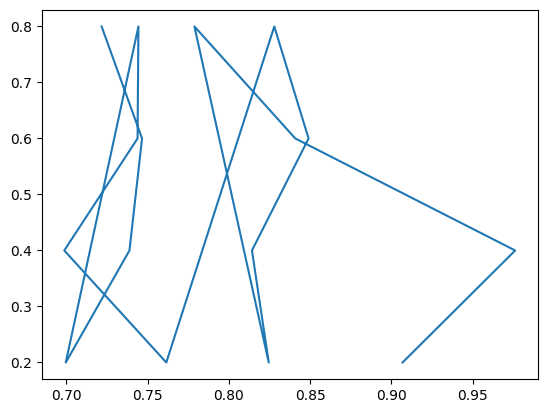

In [23]:
plt.plot(df['ebase'], df['droped_ratio'])

# HYPOTHESE

## EVOLution de l'entropie
- dépend de la taille des jeux de données
- Dépend de la distribution de probabilité
- Dépend de la méthode de calcul des classes
- Dépend de l'hétérogénéité des données 
- de l'équilibre dans la distribtution des données (uniformité)

## Comment affecter l'entropie
- destruction d'information de sorte à accentuer le déséquilibre => supprimer des valeurs dans les classes de faibles fréquence

## Comment les données manquantes peuvent affecter l'entropie
- Une donnée manquante n'apporte pas d'information
- On ne sait pas ce que aurait pu être cette donnée manquante 
- imputer les données manquante de la moyenne c'est améliorer l'entropie ?
    - 20 % de données manquantes => la classe de la moyenne obtiens 20 % de données en plus.




# STRATEGIE POUR PENALISER LES DONNEES MANQUANTES

In [45]:
sz = 1000
nanratio = 0.7
nan_size = int(sz*nanratio)
data = np.random.normal(loc=0, scale=1, size=sz)
nan_idx = np.random.choice(sz, nan_size, replace=False)
data[nan_idx] = np.nan
hist_w_nan = np.histogram(data[~np.isnan(data)], bins = 'doane', density = False)
mode = (hist_w_nan[1][np.argmax(hist_w_nan[0])] + hist_w_nan[1][np.argmax(hist_w_nan[0])])/2

freq_w_nan= hist_w_nan[0]/hist_w_nan[0].shape[0]
freq_input  = np.histogram(np.nan_to_num(data, nan = mode), bins = hist_w_nan[1], density = False)[0]/hist_w_nan[0].shape[0]
e_w_nan = entropy(freq_w_nan, base = 2) /np.log2(freq_w_nan.shape[0])
e_input = entropy(freq_input, base = 2) /np.log2(freq_w_nan.shape[0])

print('input   :', e_input)
print('nan   :', e_w_nan)

input   : 0.42934132992551605
nan   : 0.8652183798609104


In [31]:
from scipy import stats 
stats.mode(hist[0])

/tmp/ipykernel_76515/3583721348.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(hist[0])


ModeResult(mode=array([11]), count=array([2]))

In [33]:
np.argmax(hist[0])

4

In [46]:
np.argmax([1, 1, 1, 1, 1])

0